# General Travelling Sales Person with Zero Cost



In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Standard Libraries
import argparse
import json
import time
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pylab

# Custom Libraries
import qaoa_vrp.build_graph
import qaoa_vrp.features.graph_features
import qaoa_vrp.features.tsp_features
import qaoa_vrp.build_circuit
import qaoa_vrp.clustering
import qaoa_vrp.utils
from qaoa_vrp.exp_utils import str2bool, make_temp_directory
from qaoa_vrp.quantum_burden import compute_quantum_burden
from qaoa_vrp.classical.greedy_tsp import greedy_tsp
from qaoa_vrp.plot.draw_euclidean_graphs import draw_euclidean_graph

# QISKIT stuff
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver,VQE
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, NELDER_MEAD, SPSA
from qiskit.circuit import Parameter
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
)
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.applications.ising import max_cut, tsp

# import logging
# logging.basicConfig(level=logging.INFO)
# logging.getLogger('qiskit.algorithms.minimum_eigen_solvers.vqe').setLevel(logging.INFO)

/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/finance/__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimizati

In [2]:
filename="instanceType_euclidean_tsp_numNodes_4_numVehicles_1_87a170c748e240d0b71d5fb7fe7de707.json"
instance_path = "../data/{}".format(filename)
with open(instance_path) as f:
        data = json.load(f)

In [3]:
# Build Graph
G, depot_info = qaoa_vrp.build_graph.build_json_graph(data["graph"])
num_vehicles = int(data["numVehicles"])
threshold = float(data["threshold"])
n_max = int(data["n_max"])
instance_type = data["instance_type"]
p_max = data["p_max"]


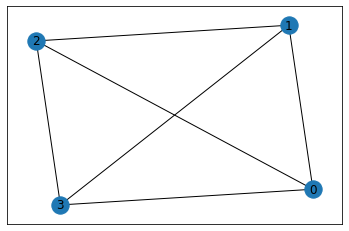

In [4]:
nx.draw_networkx(G)

In [5]:
# Create QAOA parameter dictionary
qaoa_dict = qaoa_vrp.utils.create_qaoa_params(threshold, n_max, p_max)

In [6]:
# Build Graph Feature Vector
feature_vector = qaoa_vrp.features.graph_features.get_graph_features(G)
# Build TSP Feature Vector
tsp_feature_vector = qaoa_vrp.features.tsp_features.get_tsp_features(G)
# Add num vehicles
feature_vector["num_vehicles"] = num_vehicles

In [7]:
depot_edges = list(G.edges(depot_info["id"], data=True))
depot_node = depot_info["id"]

In [17]:
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))
for edge in G.edges():
    G[edge[0]][edge[1]]['cost'] = 0
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))

In [18]:
G, cluster_mapping = qaoa_vrp.clustering.create_clusters(
    G, num_vehicles, "spectral-clustering", edge_mat
)

subgraphs = qaoa_vrp.clustering.build_sub_graphs(G, depot_node, depot_edges)

# big_offset = sum(sum(cost_mat))/2 + 1
big_offset=30
qubos = qaoa_vrp.build_circuit.build_qubos(subgraphs, depot_info,A=big_offset)

qubos_solution_data = []

cluster_mapping = [i + 1 for i in cluster_mapping]
cluster_mapping.insert(0, 0)

In [19]:
qubo = qubos[0]
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 120 X11 - 120 X12 - 120 X13 - 120 X21 - 120 X22 - 120 X23 - 120 X31
      - 120 X32 - 120 X33 + [ 120 X11^2 + 120 X11*X12 + 120 X11*X13
      + 120 X11*X21 + 120 X11*X31 + 120 X12^2 + 120 X12*X13 + 120 X12*X22
      + 120 X12*X32 + 120 X13^2 + 120 X13*X23 + 120 X13*X33 + 120 X21^2
      + 120 X21*X22 + 120 X21*X23 + 120 X21*X31 + 120 X22^2 + 120 X22*X23
      + 120 X22*X32 + 120 X23^2 + 120 X23*X33 + 120 X31^2 + 120 X31*X32
      + 120 X31*X33 + 120 X32^2 + 120 X32*X33 + 120 X33^2 ]/2 + 180
Subject To

Bounds
 0 <= X11 <= 1
 0 <= X12 <= 1
 0 <= X13 <= 1
 0 <= X21 <= 1
 0 <= X22 <= 1
 0 <= X23 <= 1
 0 <= X31 <= 1
 0 <= X32 <= 1
 0 <= X33 <= 1

Binaries
 X11 X12 X13 X21 X22 X23 X31 X32 X33
End

In [20]:
single_qubo_solution_data = {}
single_qubo_solution_data["qubo_id"] = 0
single_qubo_solution_data["cluster"] = [
    index
    for index, node in enumerate(cluster_mapping)
    if node == 1 or node == 0
]
num_nodes=len(single_qubo_solution_data['cluster'])

# Solving the QAOA

Lets write some basic functions to find the solution from the result and also one to compute the cost based on our original graph

In [21]:
op, offset = qubo.to_ising()
num_qubits = qubo.get_num_vars()

/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/operators/operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


In [22]:
print('Offset:', offset)
print('Ising Hamiltonian:')
print(op.print_details())

Offset: 180.0
Ising Hamiltonian:
IIIIIIIIZ	(-30+0j)
IIIIIIIZI	(-30+0j)
IIIIIIZII	(-30+0j)
IIIIIZIII	(-30+0j)
IIIIZIIII	(-30+0j)
IIIZIIIII	(-30+0j)
IIZIIIIII	(-30+0j)
IZIIIIIII	(-30+0j)
ZIIIIIIII	(-30+0j)
IIIIIIIZZ	(15+0j)
IIIIIIZIZ	(15+0j)
IIIIIIZZI	(15+0j)
IIIIIZIIZ	(15+0j)
IIIIZIIZI	(15+0j)
IIIIZZIII	(15+0j)
IIIZIIZII	(15+0j)
IIIZIZIII	(15+0j)
IIIZZIIII	(15+0j)
IIZIIIIIZ	(15+0j)
IIZIIZIII	(15+0j)
IZIIIIIZI	(15+0j)
IZIIZIIII	(15+0j)
IZZIIIIII	(15+0j)
ZIIIIIZII	(15+0j)
ZIIZIIIII	(15+0j)
ZIZIIIIII	(15+0j)
ZZIIIIIII	(15+0j)



/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/operators/list_ops/summed_op.py:193: DeprecationWarning: print_details() is deprecated and will be removed in a future release. Instead you can use .to_legacy_op() and call print_details() on it's output
  warnings.warn("print_details() is deprecated and will be removed in "


In [23]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;

minimize
 - 60 x_0 - 60 x_1 - 60 x_2 - 60 x_3 - 60 x_4 - 60 x_5 - 60 x_6 - 60 x_7
 - 60 x_8 [ 60 x_0*x_1 + 60 x_0*x_2 + 60 x_0*x_3 + 60 x_0*x_6 + 60 x_1*x_2
 + 60 x_1*x_4 + 60 x_1*x_7 + 60 x_2*x_5 + 60 x_2*x_8 + 60 x_3*x_4 + 60 x_3*x_5
 + 60 x_3*x_6 + 60 x_4*x_5 + 60 x_4*x_7 + 60 x_5*x_8 + 60 x_6*x_7 + 60 x_6*x_8
 + 60 x_7*x_8 ] + 180;
 
subject to {

}


In [24]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact.solve(qp)
print(exact_result)

optimal function value: 0.0
optimal value: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
status: SUCCESS


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.eigen_solvers',


In [25]:
ee = NumPyMinimumEigensolver(op)
exact_result = ee.run()

In [26]:
print('energy:', exact_result.eigenvalue.real)
print('tsp objective:', exact_result.eigenvalue.real + offset)
x = sample_most_likely(exact_result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, cost_mat))

energy: -180.0
tsp objective: 0.0
feasible: True
solution: [1, 2, 0]
solution objective: 0.0


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:215: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  unique, counts = np.unique(aqua_globals.random.choice(list(deterministic_counts.keys()),


## Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_{entangler}$.

We will show the callback usage below over a set of optimizers for comparison. Let's ensure we're giving each algorithm a fair shot.

- `SLSQP`
- `COBYLA`
- `NELDER_MEAD`
- `SPSA`
- `L_BFGS_B`

## Different Optimsiation Algorithms

### SLSQP
Sequential Least Squares Quadratic Programming. It essentially fits sequential parabolas to then minimize. The parameters we can tune include:

- `ftol`: Precision goal for the value of f in the stopping criterion. Default is 1e-06 *kept*
- `eps`: Step size used for numerical approximation of the Jacobian. Default for this is 1.5e-08, I set it to be 0.001
- `maxiter`: Maximum number of iterations (set to be 1000)
- `finite_diff_rel_step`: Default is `None`. 

SLSQP is ideal for mathematical problems for which the objective function and the constraints are twice continuously differentiable. In our case since, we're working with quadratic terms we suspect it should be good?


### COBYLA
Constrained Optimization BY Linear Approximation (COBYLA) algorithm. It is a numerical optimization method for constrained problems where the derivative of the objective function is not known.

The parameters we can play with are:
- `maxiter`: Maximum number of iterations (set to be 1000)
- `rhobeg`: Reasonable initial changes to the variables. Default is currently 1.0, I have set it to be 0.01.
- `tol`: None (default is 1e4).

### Nelder Mead
The Nelder–Mead method is a commonly applied numerical method used to find the minimum or maximum of an objective function in a multidimensional space.

- `maxfev` Maximum allowed number of function evaluations. If both maxiter and maxfev are set, minimization will stop at the first reached. Set to the budget of $b=1000$
- `tol` Tolerance for termination (set to 1e-04)
- `adaptive` Adapt algorithm parameters to dimensionality of problem. Set to `True`

### SPSA
Simultaneous perturbation stochastic approximation (SPSA). SPSA is an gradient descent method for optimizing systems with multiple unknown parameters. As an optimization method, it is appropriately suited to large-scale population models, adaptive modeling, and simulation optimization

### L-BFGS-B
Limited-memory BFGS (L-BFGS or LM-BFGS) is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory.

It assumes the objective function is a differentiable scalar function $f$. It does not require a hessian matrix. It is a method that uses limited memory, the derivatives are used to find the direction for the steepest descent.

Parameters we can tune include:

- `maxfun`: Maximum number of function evaluations.
- `factr`: The iteration stops when $\frac{(f^k - f^{k+1})}{\max{(|f^k|, |f^{k+1}|,1)}} \leq \text{factor} \times \epsilon$
- `epsilon`: Step size used (set this to be 0.001)

In [28]:
budget=70
optimizers = [
#     SLSQP(maxiter=budget, disp=True, eps=0.001),
#     COBYLA(maxiter=budget, disp=True, rhobeg=0.1), 
    NELDER_MEAD(maxfev=budget,disp=True,adaptive=True),
#     SPSA(maxiter=budget,learning_rate=0.01,perturbation=0.01),
#     L_BFGS_B(maxfun=budget,factr=10, epsilon=0.001,iprint=100)
]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
backend = Aer.get_backend('aer_simulator_matrix_product_state')



$$p = 1$$

In [29]:
p = 1
for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__))
    counts = []
    values = []
    global_count = 0
    n_restart = 0
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        global global_count
        global_count += 1
        counts.append(eval_count)
        values.append(mean)
        
    while global_count < budget:
        # Increment n_restarts
        n_restart += 1
        # Initiate a random point uniformly from [0,1]
        initial_point = [np.random.uniform(0,1) for i in range(2*p)]         
        # Set random seed
        aqua_globals.random_seed = np.random.default_rng(123)
        seed = 10598
        # Initate quantum instance
        quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
        # Initate QALA
        qaoa = QAOA(
            operator=op,
            optimizer=optimizer,
            callback=store_intermediate_result,
            p=p,
            initial_point = initial_point,
            quantum_instance=quantum_instance
        )
        result = qaoa.compute_minimum_eigenvalue(operator=op)
        converge_cnts[i] = np.asarray(counts)
        converge_vals[i] = np.asarray(values)        
    
print('\rOptimization complete');    

Optimizer: NELDER_MEAD        


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:70: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algorithms.VariationalAlgorithm (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.algorithms.VQAlgorithm',
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/components/variational_forms/variati

Optimization complete


In [30]:
results_dict = {
    "optimizer":None,
    "n_eval": None,
    "value": None
}

optimizer_dict = {
    0: "SLSQP",
    1: "COBYLA",
    2: "NELDER_MEAD",
    3: "SPSA",
    4: "L_BFGS_B"
}

d_results = []

for i,(evals, values) in enumerate(zip(converge_cnts, converge_vals)):
    for cnt, val in zip(evals, values):
        results_dict_temp = results_dict.copy()
        results_dict_temp["n_eval"] = cnt
        results_dict_temp["value"] = val
        results_dict_temp["optimizer"] = optimizer_dict[i]
        d_results.append(results_dict_temp)

d_results = pd.DataFrame.from_records(d_results)
# Add counter for num_evals
d_results['total_evals']=d_results.groupby('optimizer').cumcount()

In [31]:
d_results.to_csv("../data/results_large_offset.csv")

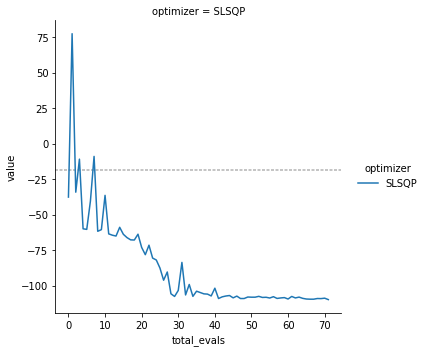

In [32]:
g = sns.relplot(
    data=d_results, x="total_evals", y="value",
    col="optimizer", hue="optimizer",
    kind="line"
)

(g.map(plt.axhline, y=-18.6, color=".7", dashes=(2, 1), zorder=0)
  .tight_layout(w_pad=0))

plt.show()

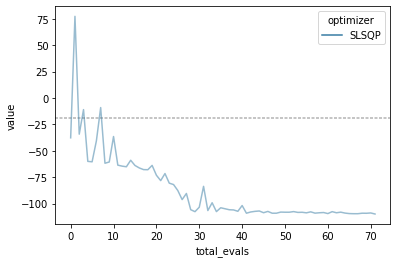

In [33]:
palette = sns.color_palette("mako_r", 1)
sns.lineplot(
    data=d_results, x="total_evals", y="value",
    hue="optimizer",
    palette=palette,
    alpha=0.5
)
plt.axhline(y=-18.6, color=".7", dashes=(2, 1), zorder=0)

In [34]:
x = sample_most_likely(result.eigenstate)
tsp.get_tsp_solution(x)

[2, 1, 0]

In [35]:
print('energy:', result.eigenvalue.real)

energy: -109.8046875


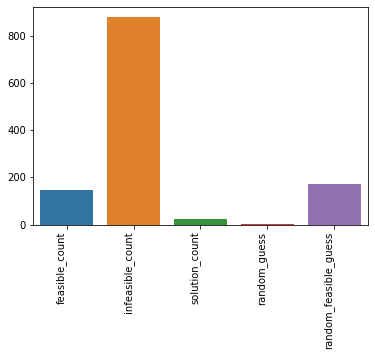

In [36]:
plt.clf()
feasible_count = 0
infeasible_count = 0
solution_count = 0
feasibility_results = {
    "feasible_count": None,
    "infeasible_count": None,
    "solution_count": None,
    "random_guess": None
}

num_feasible = len([x for x in result.eigenstate.keys() if tsp.tsp_feasible(x)])

for state in result.eigenstate.keys():
    x = sample_most_likely(exact_result.eigenstate)
    exact_sol_state = ''.join([str(i) for i in x])
    if tsp.tsp_feasible(state):
        feasible_count += result.eigenstate[state]
    else:
        infeasible_count += result.eigenstate[state]
    if exact_sol_state == state:
        solution_count = result.eigenstate[state]

feasibility_results["feasible_count"]=feasible_count
feasibility_results["infeasible_count"]=infeasible_count
feasibility_results["solution_count"]=solution_count
feasibility_results["random_guess"]=(feasible_count+infeasible_count)/2**num_qubits
feasibility_results["random_feasible_guess"]=(feasible_count+infeasible_count)/num_feasible
keys = list(feasibility_results.keys())
# # get values in the same order as keys, and parse percentage values
vals = [feasibility_results[k] for k in keys]
feasible_plot = sns.barplot(x=keys, y=vals)
feasible_plot.set_xticklabels(feasible_plot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()